In [1]:
CUDA_VISIBLE_DEVICES=6

In [2]:
import torch
import torchio

from torch.utils.data import DataLoader

import sys

from torchvision import datasets,transforms

from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np

from torch import nn

from torch.utils.data import Dataset

import warnings 

warnings.filterwarnings('ignore')

import copy

from scipy import ndimage
import random

from scipy.stats import truncnorm


import torch.nn.functional as F
import torchvision.models as models

from skimage.color import rgb2gray

from scipy import ndimage

import torch.nn.functional as F
from torchio.transforms import RandomFlip

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

import os
from datetime import datetime

from torch.utils.data import Subset

from torch.optim import lr_scheduler

from sklearn.model_selection import ShuffleSplit

from torchsummary import summary

import matplotlib.pyplot as plt

#from utils.logger import log


#from torch.utils.tensorboard import SummaryWriter
# from tensorboardX import SummaryWriter

import GPUtil
from GPUtil import showUtilization as gpu_usage

import shutil

from torchio import RandomElasticDeformation

import torch.nn.functional as F
from torch.autograd import Variable
import math
from functools import partial


#from torch.utils.tensorboard import SummaryWriter

np.random.seed(0)

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696



In [3]:
class SimCL3D_config:
    
    model = "simCLR3D"


    
    # data
    root_dir = "/mnt/30T/data/pancreas"
    dataset_name =  "pancreas3d"
    phase = 'train'
    in_h = 128
    in_w = 128
    in_d = 128
    in_c =1
    ch_first=False
    work_dir= '/mnt/home/Masoumeh.Javanbakhat'
    log_dir = '/mnt/home/Masoumeh.Javanbakhat/logs'

    
    # model pre-training
    verbose = 1
    weights = None
    batch_size = 2
    optimizer = "adam"
    num_workers = 4
    num_epochs = 100
    lr = 1
    patience = 2         # number of epochs that we update lr in lr_scheduler (StepLR, Plateuan)
    factor = 0.1         # factor that we reduce lr
    mode = 'min'
    weight_decay = 1e-4   # based on orginal simCL
    model_depth = 18
    out_dim =100
    proj_select = 1
    max_check_without_prog = 20
    

    
    val_size = 0.1
    num_proj_layers =2
    temp = 0.7
    lr_sch = 'steplr'

    # image deformation
    crop_size = 90
    flip_rate = 1
    blur_rate = 1
    gray_rate = 0.5
    strength_rate = 1
    rot_std= 6
    rot_size=1
    ctrl_pts = 4  ##### number of control points
    gamma =3
    

    
conf =  SimCL3D_config()

In [4]:
## Making a sample to test the functions 

def Sample():
    
    PATH ='/mnt/30T/data/pancreas/train'

    img_list = [img for img in os.listdir(PATH)]

    sample = np.load(os.path.join(PATH,img_list[0]))
    
    

    print(sample.shape) 
    
    return(sample)

In [5]:
input = Sample()

(128, 128, 128, 1)


## Augmentation

In [6]:


# input : 4D numpy: (channel,h,w,d)
# output: 4D numpy: (channel,h,w,d)

class RandomCropResized3d(object):
    def __init__(self,crop_size,is_training =True): 
        """Crop vol to crop_size"""
        self.is_training = is_training
        assert isinstance(crop_size, (int, tuple))
        if isinstance(crop_size, int):
            self.crop_size = (crop_size, crop_size,crop_size) 
        else:
            assert len(crop_size) == 3
            self.crop_size = crop_size
    def __call__(self,vol):
        vol= vol.squeeze()
        h_old,w_old,d_old = vol.shape[:3]
        h,w,d = self.crop_size
        if self.is_training:
            x = np.random.randint(0,h_old-h)
            y = np.random.randint(0,w_old-w)
            z = np.random.randint(0,d_old-d)
        else:
            # crop center
            x = int((h_old - h) / 2)
            y = int((w_old - w) / 2)
            z = int((d_old - d) / 2)
        vol = vol[x:x+h,y:y+w,z:z+d]
        scale = [h_old*1.0/h, w_old*1.0/w, d_old*1.0/d]
        vol = ndimage.interpolation.zoom(vol, scale, order=0) 
        # here we add the channel again
        return(vol[np.newaxis,...])
###########################################################
# Input: 4D numpy array (-,h,w,d,-)
# Output: 4D numpy array (channel,h,w,d)
    
# Fliprate from torchIO

class Flip(object):
    def __init__(self,flip_rate): 
        self.flip_rate = flip_rate
    def __call__(self,vol):
        
        if vol.shape[0]!=1:
            vol= vol.transpose((3,0,1,2))             
        rnd_flip =  RandomFlip(0,p=self.flip_rate) 
        return(rnd_flip(vol))

###########################################################################   
# TorchIO transforms takes as a sample,4D PyTorch tensors or 4D NumPy arrays 

# Input: 4D numpy array (-,h,w,d,-)
# Output: 4D numpy array (channel,h,w,d)
# Here we consider Gaussain Blure

class GaussianBlur(object):
    def __init__(self,blur_rate,min=0.1,max=2.0): 
        self.min = min
        self.max = max
        self.blur_rate = blur_rate
    def __call__(self,vol): 
        if vol.shape[0]!=1:
            vol= vol.transpose((3,0,1,2)) 
        GausBlur= torchio.transforms.RandomBlur((self.min,self.max), p=self.blur_rate)    
        vol = GausBlur(vol) 
        return(vol)

#############################################################################

## Input: (-,h,w,d,-)
## Output: (channel,h,w,d)

AXES = [(2,1),(1,3),(2,3)]
class Rotation(object):
    """
        Perform random uniaxial rotation. rotation axes are choosing at random (1 of the 3 dimensions).
        Args:
            std (float): standard dividation used for sampling rotation angles (in degrees). 
                Rotation angles are sampled from a normal distribution N~(0, std^2)
            size:...
        """
    def __init__(self,std,size=1):
        self.std = std
        self.size=size
    def __call__(self, vol):
        
        if vol.shape[0]!=1:
            vol= vol.transpose((3,0,1,2)) 
        
        d = truncnorm.rvs(-1, 1, loc=0, scale=self.std, size=self.size)
        ax = random.choice(AXES)
        ax1, ax2 = ax
        if ax1 > 3 or ax2 > 3:
            raise NotImplementedError
        order = 3  # bspline interp
        vol = ndimage.rotate(vol, d[0], ax, reshape=False, prefilter=True, order=order)
        
        return(vol)
##########################################################################
## This function is from TorchIO
# Input : -,h,w,d,-
# Output: channel, h, w ,d

## ctrl_ptn  can be a triplle or an int
class RndElsDform(object): 
    def __init__(self,ctrl_pts): 
        self.ctrl_pts = ctrl_pts 
        assert isinstance(self.ctrl_pts,(int,tuple,list))
        
        if isinstance(self.ctrl_pts,int):
            
            assert self.ctrl_pts >3,"The minimum number of ctrl_pts is 4"
            
        if isinstance(self.ctrl_pts,(list,tuple)):
            assert min(self.ctrl_pts)>3,"The minimum number of ctrl_pts is 4"
        
    def __call__(self,vol):
        
        if vol.shape[0]!=1:
            vol= vol.transpose((3,0,1,2)) 
            
        rndels = RandomElasticDeformation(num_control_points=self.ctrl_pts,locked_borders=0)
        return(rndels(vol))
    
###########################################################################
# Input:  h,w,d,channel or channel,h,w,d  ---> so first we trnasform the channel to last
# Output: h,w,d,channel

class AdjustContrast(object):
    """
    Randomly changes image intensity by gamma. Each pixel/voxel intensity is updated as::
        x = ((x - min) / intensity_range) ^ gamma * intensity_range + min
    Args:
        prob: Probability of adjustment.
        gamma (tuple of float or float): Range of gamma values.
            If single number, value is picked from (0.5, gamma), default is (0.5, 4.5).
    """
    def __init__(self, gamma=(0.5, 4.5)):
        self.gamma: Tuple[float, float]
        if not isinstance(gamma, (tuple, list)):
            
            assert gamma > 0.5, "if gamma is single number, must greater than 0.5 and value is picked from (0.5, gamma)"
            self.gamma = (0.5, gamma) 
        else:
            assert len(gamma) == 2, "gamma should be a number or pair of numbers."
            self.gamma = (gamma[0], gamma[1])
    def __call__(self, vol):
        """
        Apply the transform to `img`.
        """
        if vol.shape[0]==1:
            vol= vol.transpose((1,2,3,0))   
        epsilon = 1e-7
        vol_min = vol.min()
        vol_range = vol.max() - vol_min
        vol = np.power(((vol - vol_min) / float(vol_range + epsilon)), self.gamma) * vol_range + vol_min
        
        # here we remove the channel and add the new channel at dim=1
        vol = np.expand_dims(vol[:,:,:,1],0)
        return(vol)     

##########################################################################
class Normalize(object):
    def __init__(self):  
        pass
    def __call__(self,vol):
        vol = (vol-vol.mean())/vol.std()
        return(vol)       
############################################################################
# This class is doing pairwise agunmentation 
class PairwiseAg(object):
    def __init__(self, transform):
        self.transform = transform
    def __call__(self, vol): 
        voli = self.transform(vol)
        volj = self.transform(vol)
        return(voli,volj)
####################################################################
def get_transform(crop_size,flip_rate,std,ctrl_pts,gamma,blur_rate,phase):
    
    if phase=='train':
    
        transform = transforms.Compose([RandomCropResized3d(crop_size),
                                        Flip(flip_rate),
                                        Rotation(std),
                                        RndElsDform(ctrl_pts),
                                        AdjustContrast(gamma),
                                        GaussianBlur(blur_rate),
                                        Normalize()])
    else:
        # we do not apply any augmentation on test set
        transform = Normalize()
    return(transform)



In [7]:
transform = get_transform(conf.crop_size,conf.flip_rate,conf.rot_std,conf.ctrl_pts,conf.gamma,conf.blur_rate,conf.phase)

In [8]:
input_tr = transform(input)

In [9]:
print(input_tr.mean())

1.3271347e-07


In [10]:
print(input_tr.std())

0.9999998


## Visualizing the trasnformations

In [22]:
### A helper function to show a random list of 2d slices:    
rndImg = np.random.choice(127,2)

def imgshow(img,img_tr):
    for i in rndImg:
        print(i)
        
        plt.figure()
        plt.subplot(121)
        plt.imshow(img[:,:,i],cmap='gray')
        plt.axis("off")
        
        plt.subplot(122)
        plt.imshow(img_tr[:,:,i],cmap='gray')
        plt.axis("off")

#### RandomCropResized3d

(128, 128, 128, 1)
99
88


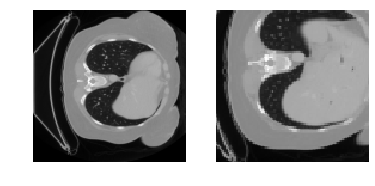

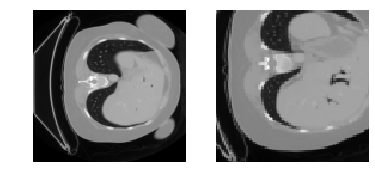

In [21]:
rnd_cr = RandomCropResized3d(90)
img = Sample()

img_tr = rnd_cr(img)

imgshow(img.squeeze(),img_tr.squeeze())

(128, 128, 128, 1)
99
88


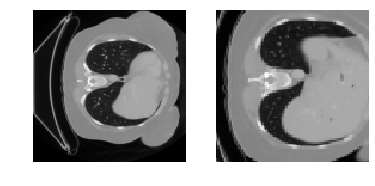

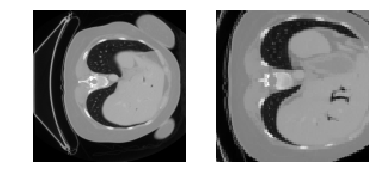

In [22]:
## random center crop
rnd_cr = RandomCropResized3d(90,False)
img = Sample()

img_tr = rnd_cr(img)

imgshow(img.squeeze(),img_tr.squeeze())

### Flip

(128, 128, 128, 1)
99
88


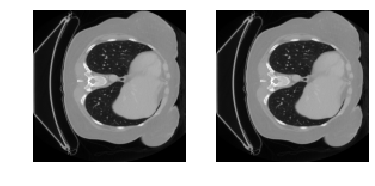

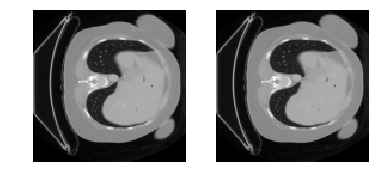

In [26]:
rnd_cr = Flip(1)
img = Sample()

img_tr = rnd_cr(img)

imgshow(img.squeeze(),img_tr.squeeze())

### GausBlur

(128, 128, 128, 1)
99
88


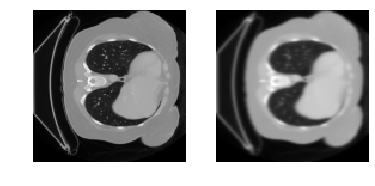

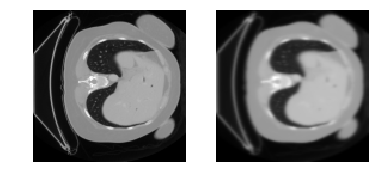

In [31]:
gaus = GaussianBlur(1)
img=Sample()
img_tr = gaus(img)
imgshow(img.squeeze(),img_tr.squeeze())

### Rotation

(128, 128, 128, 1)
99
88


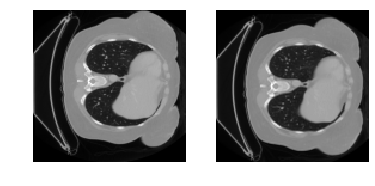

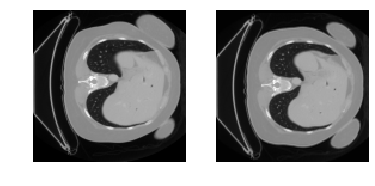

In [37]:
rot = Rotation(10)
img=Sample()
img_tr = rot(img)
imgshow(img.squeeze(),img_tr.squeeze())


### RandomElasticDeformation

(128, 128, 128, 1)
99
88


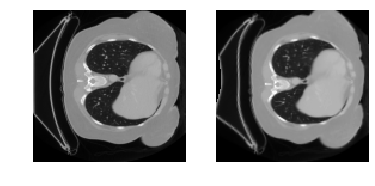

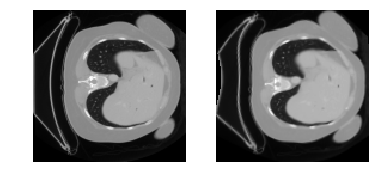

In [38]:
rnd_els = RndElsDform(9)
img=Sample()
img_tr = rnd_els(img)
imgshow(img.squeeze(),img_tr.squeeze())

### AdjustContrast

(128, 128, 128, 1)
99
88


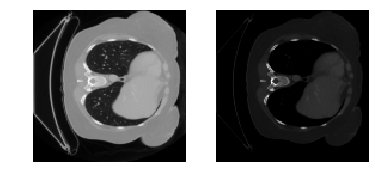

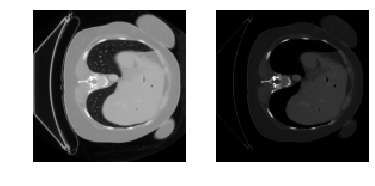

In [39]:
adj_ctr = AdjustContrast(4)
img=Sample()
img_tr = adj_ctr(img)
imgshow(img.squeeze(),img_tr.squeeze())

### All transformations

(128, 128, 128, 1)
83
21


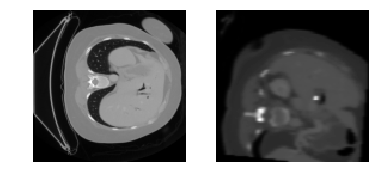

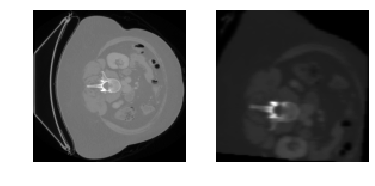

In [20]:
transform = get_transform(conf.crop_size,conf.flip_rate,conf.rot_std,conf.ctrl_pts,conf.gamma,conf.blur_rate,conf.phase)

img=Sample()
img_tr = transform(img)
imgshow(img.squeeze(),img_tr.squeeze())

## Dataset and DataLoaders

In [7]:
# Input =channel, h, w,d
# Output= channel,h,w,d

class NPDataSet(Dataset):
    
    
    def __init__(self,root_dir,phase,channel_first,transform=None):
        
        self.root_dir = root_dir
        
        VolList = sorted([volname for volname in os.listdir(os.path.join(root_dir,phase))])
        
        # path to each volume
        self.pathvol = sorted([os.path.join(self.root_dir,phase,vol) for vol in VolList])
        
        self.transform = transform
        
        self.channel_first = channel_first
        
        self.len = len(VolList)
        
        
    def __len__(self):
        
        return(self.len)
    
    
    def __getitem__(self,index):
        
        # the shape is in the form (depth,highet,width,channel)
        
        self.vol = np.load(self.pathvol[index])
        
        # cheking to see if its in the form (channel,depth,hight,width)
        
        assert len(self.vol.shape)==4
        
        # Now we transpose the axis if the order is in the shape (depth,hight,width,channel)
        
        if not self.channel_first:
            
            self.vol = np.transpose(self.vol,(3,0,1,2))
            
        
        # applying transformatios
        
        if self.transform:
            
            voli = self.transform(self.vol)
            volj =self.transform(self.vol)
            
        return(voli,volj)      

In [12]:
transform = get_transform(conf.crop_size,conf.flip_rate,conf.rot_std,conf.ctrl_pts,conf.gamma,conf.blur_rate,conf.phase)

dataset = NPDataSet(conf.root_dir,conf.phase,conf.ch_first,transform) 


In [13]:
## Checking some items in datasets

for item in dataset:
    print(len(item),item[0].shape,item[0].dtype, type(item[0]))
    break

2 (1, 128, 128, 128) float32 <class 'numpy.ndarray'>


## Dataloaders 

In [8]:
# I set val_size=0, because if we want to download tsetset then we do not require val_set

# during training we should pass conf.batch_size,conf.num_workers,con.val_size

def get_teain_val_loader(dataset,batch_size,num_workers,val_size=0):
    
    if val_size:
        
        assert val_size < 1., "Invalid argument for split: {}".format(val_split)
        
        ## calculate splits
        
        split = ShuffleSplit(n_splits=1, test_size =val_size, random_state=0)
        
        # Create lists
        indices = range(len(dataset))
        
        for train_index, val_index in split.split(indices):
            
            train_ind = train_index
            val_ind = val_index
            
        
        train_set = Subset(dataset,train_ind)


        val_set = Subset(dataset,val_ind)
        
        train_loader = DataLoader(train_set, batch_size=batch_size,num_workers=num_workers, drop_last=True, shuffle=True)
        
        val_loader = DataLoader(val_set, batch_size=batch_size,num_workers=num_workers, drop_last=True, shuffle=True)
        
        return(train_loader,val_loader)
        
    else:
        
        data_loader  = DataLoader(dataset, batch_size=batch_size,num_workers=num_workers, drop_last=True, shuffle=False)
        
        return(data_loader)  

In [9]:
## Check the correctness of data loaders

transform = get_transform(conf.crop_size,conf.flip_rate,conf.rot_std,conf.ctrl_pts,conf.gamma,conf.blur_rate,conf.phase)

dataset = NPDataSet(conf.root_dir,conf.phase,conf.ch_first,transform)

train_loader, val_loader = get_teain_val_loader(dataset,conf.batch_size,conf.num_workers,conf.val_size)

In [10]:
for item in train_loader:
    print(len(item),item[0].shape, item[0].max(),item[0].min())

    break

2 torch.Size([2, 1, 128, 128, 128]) tensor(12.2312) tensor(-1.3557)


In [11]:
for item in val_loader:
    print(len(item),item[0].shape, item[0].max(), item[0].min())
    break

2 torch.Size([2, 1, 128, 128, 128]) tensor(14.3050) tensor(-2.5635)


## Defining model

In [9]:
# **Input**: (N,C_{in},D_{in},H_{in},W_{in})
# **Output**: (N,C_{out},D_{out},H_{out},W_{out})


def conv3x3x3(in_ch, out_ch, stride=1, dilation=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_ch,
        out_ch,
        kernel_size=3,
        dilation=dilation,
        stride=stride,
        padding=dilation,
        bias=False)

##############################################################
# planes is changed to out_ch

# I deleted no_cuda from the arguments of this function
def downsample_basic_block(x, out_ch, stride):
    
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(
        out.size(0), out_ch - out.size(1), out.size(2), out.size(3),
        out.size(4)).zero_()
    #if not no_cuda:
        #if isinstance(out.data, torch.cuda.FloatTensor):
            #zero_pads = zero_pads.cuda()

    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return(out)

###################################################################
# Basic blocks do not include relu at the end of operation

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_ch, out_ch, stride=1, dilation=1, downsample=None):
        
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3x3(in_ch, out_ch, stride=stride, dilation=dilation)
        
        self.bn1 = nn.BatchNorm3d(out_ch)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3x3(out_ch, out_ch, dilation=dilation)
        
        self.bn2 = nn.BatchNorm3d(out_ch)
        
        self.downsample = downsample
        
        self.stride = stride
        
        self.dilation = dilation
        
    def forward(self, x):
        
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        #print(f'out_size{out.size()}')

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return(out)
######################################################################################    
class Bottleneck(nn.Module):
    
    expansion = 4

    def __init__(self, in_ch, out_ch, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(in_ch, out_ch, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_ch)
        self.conv2 = nn.Conv3d(
            out_ch, out_ch, kernel_size=3, stride=stride, dilation=dilation, padding=dilation, bias=False)
        
        self.bn2 = nn.BatchNorm3d(out_ch)
        self.conv3 = nn.Conv3d(out_ch, out_ch * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(out_ch * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return(out)

############################################################################
# input : N,C,D,H,W

class ResNet(nn.Module):

    def __init__(self,
                 in_channels,
                 block,
                 layers,
                 #num_classes,
                 shortcut_type='B'):
                 # I deleted no_cuda from this line
        
        self.in_ch = 64
        
        #self.no_cuda = no_cuda
        super(ResNet, self).__init__()
        
        
        # the first step in Resnet is a conv+batch+max_pool
        # kernel_size =7
        # feature_map =64
        # zero_padding =3 times in each dimension (112x112x112x64)
        # here we set 1 as the input channel, because we have gray scale medical images
        self.conv1 = nn.Conv3d(
            in_channels,
            64,
            kernel_size=7,
            stride=(2, 2, 2),
            padding=(3, 3, 3),
            bias=False)
        
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0], shortcut_type)
        
        self.layer2 = self._make_layer(block, 128, layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], shortcut_type, stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], shortcut_type, stride=1, dilation=4)
        
        self.avgpool = nn.AvgPool3d(kernel_size=7, stride=1)
        
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        
    
    # here we convert planes to out_ch
    # here we convert self.inplanes to self.in_ch
    
    def _make_layer(self, block, out_ch, blocks, shortcut_type, stride=1, dilation=1):
        
        downsample = None
        
        if stride != 1 or self.in_ch != out_ch * block.expansion:
            
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    
                    out_ch=out_ch * block.expansion,
                    stride=stride)
                    # I deleted no_cuda from this line
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.in_ch,
                        out_ch * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False), nn.BatchNorm3d(out_ch * block.expansion))
        
        # Here basic block or bottelneck bloc is added to the layers
        layers = []
        layers.append(block(self.in_ch, out_ch, stride=stride, dilation=dilation, downsample=downsample))
        self.in_ch = out_ch * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_ch, out_ch, dilation=dilation))

        return(nn.Sequential(*layers))
    
    
    def forward(self, x):
        x = self.conv1(x)        #224x224
        #print(f'x1{x.size()}')
        
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)      #112x112 
        #print(f'x2{x.size()}')                      
        
        x = self.layer1(x)       #56x56
        #print(f'x3{x.size()}')
        x = self.layer2(x)       #28x28
        #print(f'x4{x.size()}')
        x = self.layer3(x)       #14x14
        #print(f'x5{x.size()}')
        x = self.layer4(x)       #7x7
        #print(f'x6{x.size()}')
        
        x = self.avgpool(x)
        
        #print(f'x7{x.size()}')
        
        
        # here we suppose that channel is fisrt
        h = torch.mean(x,[2,3,4])        
        return(x,h)
    
###################################################################    
def generate_resnet3D(model_depth,in_channels,**kwargs):
    
    assert model_depth in [18,34,50,101,152,200]
    
    resnet_dict = {18:[2, 2, 2, 2],34:[3, 4, 6, 3],50:[3, 4, 6, 3],101:[3, 4, 23, 3],152: [3, 8, 36, 3], 200: [3, 24, 36, 3]}
    
    if model_depth ==18:
        
        model =ResNet(in_channels,BasicBlock, resnet_dict[model_depth],**kwargs)
        
    elif model_depth==34:
        
        model = ResNet(in_channels,BasicBlock,resnet_dict[model_depth],**kwargs)
        
    elif model_depth==50:
        
        model = ResNet(in_channels,Bottleneck,resnet_dict[model_depth],**kwargs)
    
    elif model_depth ==101:
        
        model = ResNet(in_channels,Bottleneck,resnet_dict[model_depth],**kwargs)
        
    elif model_depth ==150:
        
        model = ResNet(in_channels,Bottleneck,resnet_dict[model_depth],**kwargs)
        
    elif model_depth ==200:
        
        model = ResNet(in_channels,Bottleneck,resnet_dict[model_depth],**kwargs)
        
    return(model)

In [9]:
## Checking the model 

transform = get_transform(conf.crop_size,conf.flip_rate,conf.rot_std,conf.ctrl_pts,conf.gamma,conf.blur_rate,conf.phase)

dataset = NPDataSet(conf.root_dir,conf.phase,conf.ch_first,transform) 

train_loader, val_loader = get_teain_val_loader(dataset,conf.batch_size,conf.num_workers,conf.val_size)

# checking Resnet 101

model = generate_resnet3D(101,1) 

device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

print(next(model.parameters()).device)

## applying on a batch

for v1,v2 in train_loader:
    x1,h1 = model(v1.to(device))
    
    x2,h2 = model(v2.to(device))
    
    print(x1.shape,h1.shape)
    print(x2.shape,h2.shape)
    
    break
    
    

cuda:4
torch.Size([2, 2048, 10, 10, 10]) torch.Size([2, 2048])
torch.Size([2, 2048, 10, 10, 10]) torch.Size([2, 2048])


In [11]:
torch.cuda.empty_cache()

gpu_usage()

| ID | GPU | MEM  |
-------------------
|  0 |  0% | 100% |
|  1 | 44% |  99% |
|  2 | 56% |  72% |
|  3 | 42% |  64% |
|  4 |  0% |  87% |
|  5 | 23% |  99% |
|  6 |  0% |   2% |
|  7 |  0% |   2% |


In [ ]:
#checking Resnet18
model = generate_resnet3D(18,1) 

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

print(next(model.parameters()).device)

## applying on a batch

for v1,v2 in train_loader:
    x1,h1 = model(v1.to(device))
    
    x2,h2 = model(v2.to(device))
    
    print(x1.shape,h1.shape)
    print(x2.shape,h2.shape)
    
    break

In [ ]:
## Here I tried to use ModelParallel but it didn't split the batch

gpu_usage()

model = nn.DataParallel(model,device_ids=[0,1])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model.to(device)

input = torch.randn(2,1,128,128,128)

input.to(device)

output1, output2 = model(input)

print("Outside: input size", input.size(),
          "output_size", output2.size())

torch.cuda.empty_cache()

sys.stdout.flush()

## Projection map

In [10]:
def projection_head(hiddens,num_proj_layers,out_dim,proj_select,device): 
    """It performs a projectuion head for contrastive loss
       
       Args:
            hiddens, a Tensor of dim [bsz,dim]
            is_training, 
            num_proj_layers, the number of hidden layers that we wnat to have
            
      Output:
             It returns the projection of the layer that we want
    """ 
    
    mid_dim = hiddens.shape[-1]
    out_dim = out_dim
    list_hiddens = []
    
    
    for j in range(num_proj_layers):
        
        if j!= num_proj_layers-1:
            
            dim = mid_dim
            
        else:
            
            dim = out_dim
            
        hiddens = linear_layer(hiddens,dim,device)
        
        hiddens = F.relu_(hiddens)
        
        list_hiddens.append(hiddens)
        
    return(list_hiddens[proj_select])


def linear_layer(x,dim,device):
    
    fc = nn.Linear(x.size(-1),dim).to(device)
    
    x = fc(x)
    
    return(x)
  

In [14]:
## Checking the correctness of the code


h1 = h1.to(device)
h2 = h2.to(device)
proj1 = projection_head(h1,2,128,1,device)
proj2 = projection_head(h2,2,128,1,device)


print(proj1.shape)
print(proj2.shape)


torch.Size([2, 128])
torch.Size([2, 128])


## Contrastive Loss

In [11]:
LARGE_NUM = 1e9

# Input : tensors [bsz, dim]  = [bsz,128]

# Output: tensor scalar loss

class ConLoss(nn.Module):
    
    """Compute loss for model"""

    def __init__(self,temperature,device,is_normalized = True):
        
        super(ConLoss, self).__init__()
        
        """
        Args: 
            
            is_normalized: whether or not to use normalization on the hidden vector
            temperature: a `floating` number for temperature scaling
            
        Outputs:
        
            A loss scalar
        """
        self.temperature = temperature
        self.is_normalized  = is_normalized 
        self.device = device
        

    def forward(self, hi,hj):
        
        #hi,hj:`Tensors` hidden vector of shape [bsz,dim=128]
        
        for h in [hi,hj]:
            
            if len(h.shape) < 2:
                
                raise ValueError('`features` needs to be [bsz, dim],'
                             'at least 2 dimensions are required')
                
        if self.is_normalized:
            
            hi= F.normalize(hi, dim=1)
            hj= F.normalize(hj, dim=1)
            
        batch_size = hi.shape[0]
        
        targets = torch.arange(batch_size,dtype=torch.long).to(self.device)
        
        mask = F.one_hot(torch.arange(0,batch_size),batch_size).type(torch.float).to(self.device)

        logits_ii = torch.div(torch.matmul(hi,hi.T),self.temperature).to(self.device)
        
        logits_ii = (logits_ii - mask * LARGE_NUM)
        
        logits_jj = torch.div(torch.matmul(hj,hj.T),self.temperature).to(self.device)  # [bsz,bsz]
        logits_jj = (logits_jj - mask * LARGE_NUM)
        
        logits_ij = torch.div(torch.matmul(hi,hj.T),self.temperature).to(self.device)   #[bsz,bsz]

        
        logits_ji = torch.div(torch.matmul(hj,hi.T),self.temperature).to(self.device)   #[bsz,bsz]
        
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum")
    
        pos1 = torch.cat((logits_ij,logits_ii),dim=1)
        
        pos2 = torch.cat((logits_ji,logits_jj),dim=1)
        
        loss_i = self.criterion(pos1,targets)    #[bsz,2*bsz]
        loss_j = self.criterion(pos2,targets)    #[bsz,2*bsz]
        
        loss = loss_i + loss_j
        
        return(loss)

In [16]:
## Checking loss

a = torch.randn(2,128).type(torch.float)

b = torch.randn(2,128).type(torch.float)

crietrion= ConLoss(temperature=0.07)

print(a.shape, b.shape)

loss = crietrion(a,b)

print(loss.item())

torch.Size([2, 128]) torch.Size([2, 128])
5.880223751068115


In [25]:
a = torch.tensor([[ 0.0448,  1.3927, -0.0513,  0.4720, -0.4324],
        [ 0.9079,  2.0365, -1.4071,  0.1201, -0.0585]])

b = torch.tensor([[ 0.1195,  1.2307, -0.3542,  0.6821, -0.9034],
        [-1.2430,  0.2513, -0.2622, -1.1014, -1.3610]])
crietrion= ConLoss(temperature=0.07)

loss = crietrion(a,b)

print(loss.item())


15.888676643371582


In [24]:
a = torch.randn(2,5).type(torch.float)

b = torch.randn(2,5).type(torch.float)

crietrion= ConLoss(temperature=0.07)

print(a.shape, b.shape)

loss = crietrion(a,b)

print(loss.item())

print(a)

print(b)

torch.Size([2, 5]) torch.Size([2, 5])
15.888477325439453
tensor([[ 0.0448,  1.3927, -0.0513,  0.4720, -0.4324],
        [ 0.9079,  2.0365, -1.4071,  0.1201, -0.0585]])
tensor([[ 0.1195,  1.2307, -0.3542,  0.6821, -0.9034],
        [-1.2430,  0.2513, -0.2622, -1.1014, -1.3610]])


## Model Utils

In [12]:
# Here we should pass the model and optim that is conf.optimizer
# and let us to choose an appropriate optimzier

# Note that here I do not use lars optimizer, because lars optimizer is used for large
# batch sizes that here it dose not make sense



# Input: model, conf.optimizer, conf.lr,conf.weight_decay

def get_optimizer(model,opt,lr,weight_decay):
    
    if opt=='adam':
        
        optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
        
    return(optimizer)

#############################################################
# Now we define a learning_rate scheduler
# here we should pass the optimizer that we want to use

def get_lr_scheduler(lr_sch,opt,patience,factor,mode):
    
    if lr_sch =='plateau':
        
        from torch.optim.lr_scheduler import ReduceLROnPlateau 
        lr_schedul = ReduceLROnPlateau(
        opt, mode=mode,
        factor=factor,
        patience=patience,
        verbose=True)
            
    elif lr_sch =='steplr':
        
        from torch.optim.lr_scheduler import StepLR
        
        lr_schedul= StepLR(opt,step_size=patience,gamma=factor)
            
    elif lr_sch:
        
        raise ValueError("Unknown lr_scheduler: " + lr_sch) 
        
    else:
        
        lr_schedul = None
        
    return(lr_schedul)

################################################################

def get_lr(opt):
    
    for param_group in opt.param_groups:
        
        return(param_group['lr'])
##################################################################
    
    
def get_log_dir(log_dir):
    
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    
    logdir = "{}/run-{}/".format(os.path.join(log_dir,'simCLR'), now)
    
    return(logdir)
    
        

In [18]:
## Testing optimizer

# optimizer was defined sucssesfully
model = generate_resnet3D(101,1) 

optimizer = get_optimizer(model,conf.optimizer,conf.lr,conf.weight_decay)

##############################

lr_sch = get_lr_scheduler(conf.lr_sch,optimizer,conf.patience,conf.factor,conf.mode)

print(lr_sch)

# Test lr_scheduler
for i in range(10):
    
    lr_sch.step()
    
    print("epoch %s, lr: %.1e" %(i,get_lr(optimizer)))

epoch 0, lr: 1.0e-01
epoch 1, lr: 1.0e-02
epoch 2, lr: 1.0e-02
epoch 3, lr: 1.0e-03
epoch 4, lr: 1.0e-03
epoch 5, lr: 1.0e-04
epoch 6, lr: 1.0e-04
epoch 7, lr: 1.0e-05
epoch 8, lr: 1.0e-05
epoch 9, lr: 1.0e-06


## 3DsimCLR

In [13]:
conf =  SimCL3D_config()

In [14]:
print("torch = {}".format(torch.__version__))

CUDA_VISIBLE_DEVICES=6



# It displays configirations
# conf.display()


# print("Initial GPU Usage")
gpu_usage()


# Here we define the device

device=torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')




# defining model 
model = generate_resnet3D(conf.model_depth,conf.in_c)



#model = nn.DataParallel(model, device_ids = [6,7])

model.to(device)
print(next(model.parameters()).device)


# It prints a summary of the model
# summary(model, (1,conf.in_d,conf.in_h,conf.in_w), batch_size=-1)

optimizer = get_optimizer(model,conf.optimizer,conf.lr,conf.weight_decay)

scheduler = get_lr_scheduler(conf.lr_sch,optimizer,conf.patience,conf.factor,conf.mode)

transform = get_transform(conf.crop_size,conf.flip_rate,conf.rot_std,conf.ctrl_pts,conf.gamma,conf.blur_rate,conf.phase)

train_set = NPDataSet(conf.root_dir,conf.phase,conf.ch_first,transform)

train_loader, val_loader = get_teain_val_loader(train_set,conf.batch_size,conf.num_workers,conf.val_size)

torch = 1.5.1
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% | 99% |
|  2 | 69% | 57% |
|  3 | 66% | 66% |
|  4 |  0% | 16% |
|  5 |  0% | 16% |
|  6 |  0% |  0% |
|  7 | 31% | 40% |
cuda:6


In [15]:
def train(epoch):
    
    #print(f'============================')
    #print(f'|     Training is started    |')
    #print(f'============================')
    
    model.train()
    
    # to track the training loss as the model trains
    train_losses = 0
    
    for num,(vol1,vol2) in  enumerate(train_loader):
        
        Num = len(train_loader.dataset)
        
        # first we change volums to torch tensors
        vol1 = vol1.to(device)
        vol2 = vol2.to(device)

        
        # next we apply the model to get representations
        
        x1,h1 = model(vol1)
        x2,h2 = model(vol2)
        
        
        #print("Outside: input size", vol1.size(),
        #  "output_size", x1.size())
        

        
        # Now we apply the projection head to get the projection map
        proj1=projection_head(h1,conf.num_proj_layers,conf.out_dim,conf.proj_select,device)
        proj2=projection_head(h1,conf.num_proj_layers,conf.out_dim,conf.proj_select,device)

        del h1,h2
        
        #print("GPU Usage after deleting h1,h2")
        #gpu_usage()
        
        
        # now we apply contrastive loss
        criterion = ConLoss(conf.temp,device)
        loss = criterion(proj1,proj2)
        
        del proj1,proj2
        
        train_losses+= loss.item()
        optimizer.zero_grad()
        
        loss.backward()
        
        del loss
        #print("GPU Usage after deleting loss")
        #gpu_usage()
        
        optimizer.step()
        
        
    torch.cuda.empty_cache()
    #print("GPU Usage after emptying the cache")
    #gpu_usage()
    
    return(train_losses/Num)

In [16]:
def val():
    
    #print(f'============================')
    #print(f'|   Validation is started   |')
    #print(f'============================')
    
    model.eval()
    
    # to track the training loss as the model trains
    val_losses = 0
    
    for num,(vol1,vol2) in  enumerate(val_loader):
        
        Num = len(val_loader.dataset)
        
        # first we change volums to torch tensors
        vol1 = vol1.to(device)
        vol2 = vol2.to(device)

        
        # next we apply the model to get representations
        
        x1,h1 = model(vol1)
        x2,h2 = model(vol2)
        
        
        #print("Outside: input size", vol1.size(),
        #  "output_size", x1.size())
        

        
        # Now we apply the projection head to get the projection map
        proj1=projection_head(h1,conf.num_proj_layers,conf.out_dim,conf.proj_select,device)
        proj2=projection_head(h1,conf.num_proj_layers,conf.out_dim,conf.proj_select,device)

        del h1,h2
        
        #print("GPU Usage after deleting h1,h2")
        #gpu_usage()
        
        
        # now we apply contrastive loss
        criterion = ConLoss(conf.temp,device)
        loss = criterion(proj1,proj2)
        
        del proj1,proj2
        
        val_losses+= loss.item()
        
        del loss
        
    

    torch.cuda.empty_cache()
    #print("GPU Usage after emptying the cache")
    #gpu_usage()
    
    return(val_losses/len(val_loader.dataset))

In [17]:

history_loss = {'avg_train_loss':[], 'avg_val_loss':[]}
                  
best_loss = float('inf')
check_without_progress = 0

for epoch in range(conf.num_epochs):
    
    print(f'Epoch: {epoch+1}/{conf.num_epochs}')           
    
    print(f'lr = {get_lr(optimizer):0.8f}')
                  
                  
                  
    train_loss = train(epoch)
                  
                  
    val_loss = val()
                  
                  
    history_loss['avg_train_loss'].append(train_loss)
                  
    history_loss['avg_val_loss'].append(val_loss)
                  
    print("Epoch:{} | Train_Loss:{:.4f} | Val_Loss:{:.4f}".format(epoch+1,train_loss,val_loss))
                  
    if val_loss < best_loss:
                  
        print('Val_Loss decreases from {:.4f} to {:.4f}'.format(best_loss,val_loss))
                  
        best_loss = val_loss
                  
        check_without_progress = 0        
        # save checkpoint       
        torch.save({ 
            'epoch':epoch+1,
            'state_dict':model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Loss': val_loss
        },os.path.join(conf.work_dir,'checkpoint/simCLR/ck_3DsimCL.pt'))
                  
    else:
        
        print("Validation loss does not decrease from {:.4f}, checks_without_progress:{}".format(best_loss,check_without_progress))
        check_without_progress += 1
        
    # Update lr_scheduler              
    if conf.lr_sch =='plateau':
                  
        scheduler.step(val_loss)
                  
    elif conf.lr_sch =='steplr':
                  
        scheduler.step()
        
    if check_without_progress == conf.max_check_without_prog:
        
        print("Early Stopping!")
        break
    sys.stdout.flush()

Epoch: 1/100
lr = 1.00000000
Epoch:1 | Train_Loss:2.7305 | Val_Loss:3.1365
Val_Loss decreases from inf to 3.1365
Epoch: 2/100
lr = 1.00000000
Epoch:2 | Train_Loss:2.6097 | Val_Loss:3.0416
Val_Loss decreases from 3.1365 to 3.0416
Epoch: 3/100
lr = 0.10000000
Epoch:3 | Train_Loss:2.4900 | Val_Loss:3.0446
Validation loss does not decrease from 3.0416, checks_without_progress:0
Epoch: 4/100
lr = 0.10000000
Epoch:4 | Train_Loss:2.4432 | Val_Loss:3.0691
Validation loss does not decrease from 3.0416, checks_without_progress:1
Epoch: 5/100
lr = 0.01000000
Epoch:5 | Train_Loss:2.4352 | Val_Loss:2.6174
Val_Loss decreases from 3.0416 to 2.6174
Epoch: 6/100
lr = 0.01000000
Epoch:6 | Train_Loss:2.4097 | Val_Loss:2.6572
Validation loss does not decrease from 2.6174, checks_without_progress:0
Epoch: 7/100
lr = 0.00100000
Epoch:7 | Train_Loss:2.4020 | Val_Loss:2.6521
Validation loss does not decrease from 2.6174, checks_without_progress:1
Epoch: 8/100
lr = 0.00100000
Epoch:8 | Train_Loss:2.3969 | Val_